In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --------------------------------------------
# 1. GPU VRAM Limit
# --------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
# --------------------------------------------
# 2. Configuration
# --------------------------------------------
IMAGE_DIR = r"D:\CHESTXRAY\IMAGES"
CSV_PATH = r"C:\Users\dell\Desktop\CheXzero\content\Data_Entry_2017.csv"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 5

In [3]:
import os

folder_path = r"D:\CHESTXRAY\IMAGES"
num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"Number of files in {folder_path}: {num_files}")

Number of files in D:\CHESTXRAY\IMAGES: 94999


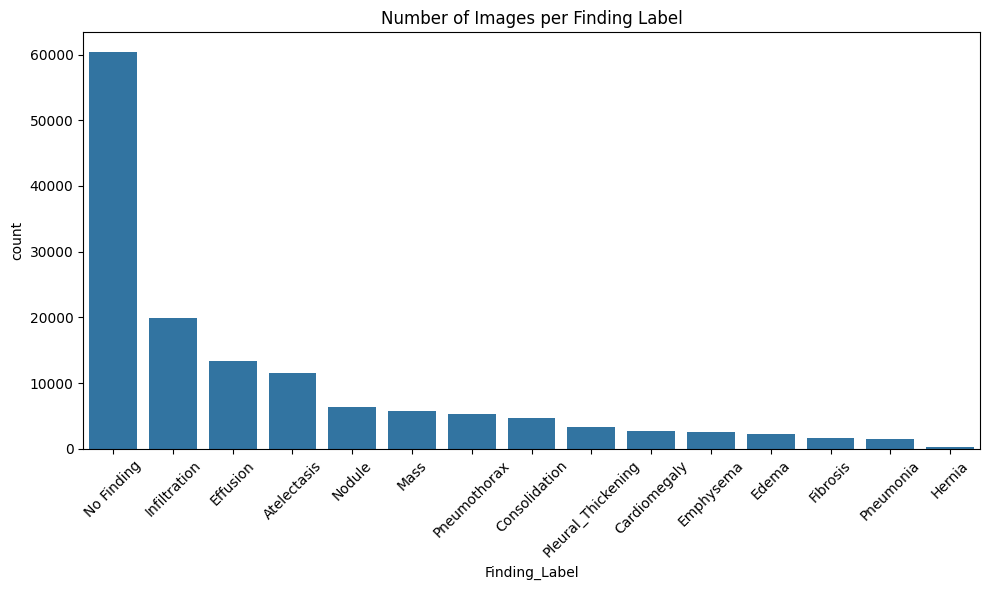

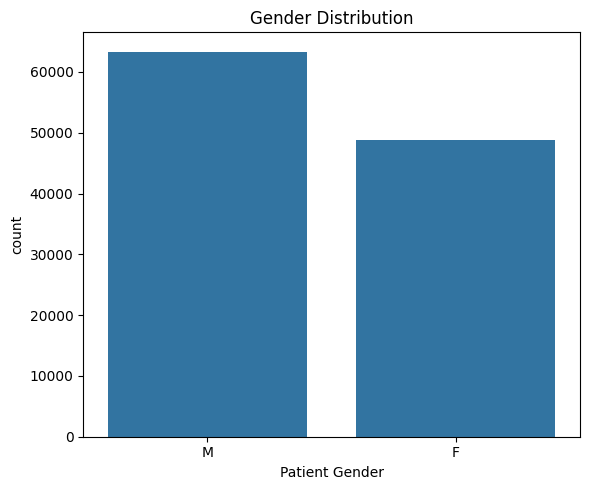

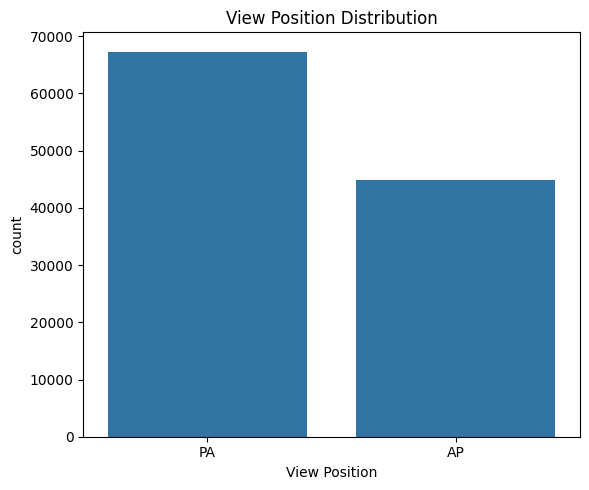

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

df = pd.read_csv(r"C:\Users\dell\Desktop\CheXzero\content\Data_Entry_2017.csv")

# Explode the finding labels into individual rows
df_exploded = df.assign(Finding_Label=df['Finding Labels'].str.split('|')).explode('Finding_Label')

# Plot 1: Number of images per finding label
plt.figure(figsize=(10, 6))
sns.countplot(data=df_exploded, x='Finding_Label', order=df_exploded['Finding_Label'].value_counts().index)
plt.title('Number of Images per Finding Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 4: Gender distribution
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='Patient Gender')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

# Plot 5: View Position distribution
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='View Position')
plt.title('View Position Distribution')
plt.tight_layout()
plt.show()


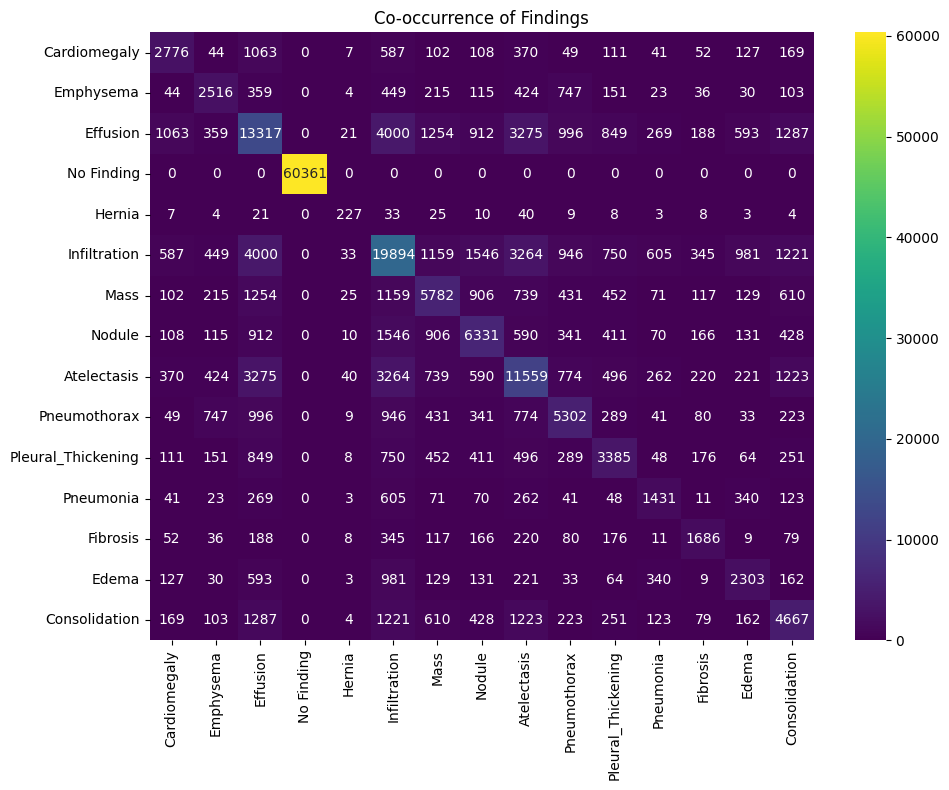

In [5]:
from itertools import combinations
import numpy as np

# Generate co-occurrence matrix
all_labels = df_exploded['Finding_Label'].unique()
co_matrix = pd.DataFrame(0, index=all_labels, columns=all_labels)

# Count co-occurrence
for labels in df['Finding Labels']:
    findings = labels.split('|')
    for a, b in combinations(findings, 2):
        co_matrix.loc[a, b] += 1
        co_matrix.loc[b, a] += 1
    for label in findings:
        co_matrix.loc[label, label] += 1  # diagonal

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap='viridis')
plt.title("Co-occurrence of Findings")
plt.tight_layout()
plt.show()


In [8]:
# --------------------------------------------
# 3. Load and Preprocess CSV
# --------------------------------------------
df = pd.read_csv(CSV_PATH)
df = df[df["Image Index"].isin(os.listdir(IMAGE_DIR))].reset_index(drop=True)
df["labels"] = df["Finding Labels"].str.split('|')
df["labels"] = df["labels"].apply(lambda x: [label.strip() for label in x if label.strip() != ""])

mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(df["labels"])
class_names = mlb.classes_
NUM_CLASSES = len(class_names)

# --------------------------------------------
# 4. tf.data Input Pipeline
# --------------------------------------------
def process_path(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

image_paths = [os.path.join(IMAGE_DIR, fname) for fname in df["Image Index"]]
labels_np = np.array(binary_labels).astype(np.float32)

full_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_np))
full_ds = full_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
full_ds = full_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
print(class_names)

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [10]:
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 15


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
# --------------------------------------------
# 5. Build Model
# --------------------------------------------
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(NUM_CLASSES, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [13]:
# --------------------------------------------
# 6. Setup ModelCheckpoint callback to save model after each epoch
# --------------------------------------------
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints/chest_xray_epoch_{epoch:02d}.h5',
    save_freq='epoch',
    save_best_only=False,
    verbose=1
)


In [15]:
# --------------------------------------------
# 7. Training with callback
# --------------------------------------------
model.fit(full_ds, epochs=5, callbacks=[checkpoint_callback])

print("✅ Models saved after each epoch")

Epoch 1/5
5938/5938 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.5536
Epoch 1: saving model to checkpoints\chest_xray_epoch_01.h5
5938/5938 [==============================] - 1349s 227ms/step - loss: 0.1819 - accuracy: 0.5536
Epoch 2/5
5938/5938 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.5667
Epoch 2: saving model to checkpoints\chest_xray_epoch_02.h5
5938/5938 [==============================] - 1345s 226ms/step - loss: 0.1728 - accuracy: 0.5667
Epoch 3/5
5938/5938 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.5901
Epoch 3: saving model to checkpoints\chest_xray_epoch_03.h5
5938/5938 [==============================] - 1339s 225ms/step - loss: 0.1605 - accuracy: 0.5901
Epoch 4/5
5938/5938 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.6333
Epoch 4: saving model to checkpoints\chest_xray_epoch_04.h5
5938/5938 [==============================] - 1339s 225ms/step - loss: 0.1402 - accur

In [8]:
model.save("./content/chest_xray_multilabel_model_tf2.h5")

In [16]:
# --------------------------------------------
# 7. Evaluation (F1, Precision, Recall)
# --------------------------------------------
# Collect all predictions
y_true, y_pred = [], []

for batch in full_ds:
    images, labels = batch
    preds = model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append((preds > 0.5).astype(int))

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f"🔍 F1 Score: {f1:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

1/1 [==============================] - 0s 21ms/step
🔍 F1 Score: 0.3572
✅ Precision: 0.7191
📌 Recall: 0.2890


c:\Users\dell\anaconda3\envs\Tensor-2.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model('checkpoints/chest_xray_epoch_05.h5')

# Continue training for more epochs (e.g., 5 more)
model.fit(full_ds, initial_epoch=5, epochs=10, callbacks=[checkpoint_callback])


Epoch 6/10
5938/5938 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.7591
Epoch 6: saving model to checkpoints\chest_xray_epoch_06.h5
5938/5938 [==============================] - 1350s 227ms/step - loss: 0.0851 - accuracy: 0.7591
Epoch 7/10
5938/5938 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.7986
Epoch 7: saving model to checkpoints\chest_xray_epoch_07.h5
5938/5938 [==============================] - 1358s 228ms/step - loss: 0.0673 - accuracy: 0.7986
Epoch 8/10
5938/5938 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.8239
Epoch 8: saving model to checkpoints\chest_xray_epoch_08.h5
5938/5938 [==============================] - 1363s 229ms/step - loss: 0.0542 - accuracy: 0.8239
Epoch 9/10
5938/5938 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.8424
Epoch 9: saving model to checkpoints\chest_xray_epoch_09.h5
5938/5938 [==============================] - 1344s 226ms/step - loss: 0.0451 - a

1/1 [==============================] - 0s 32ms/step


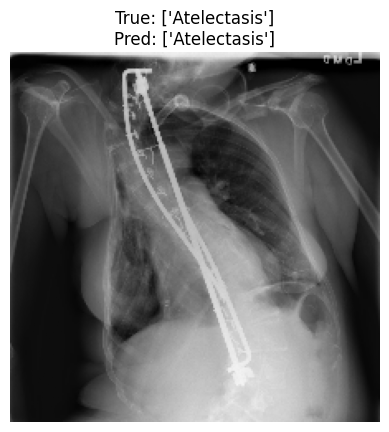

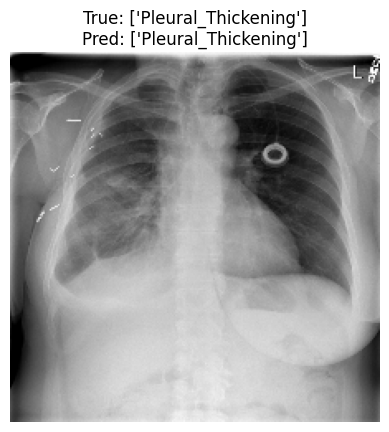

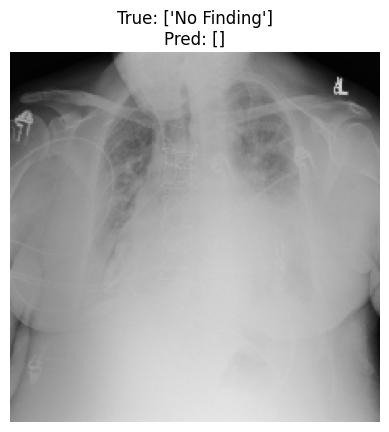

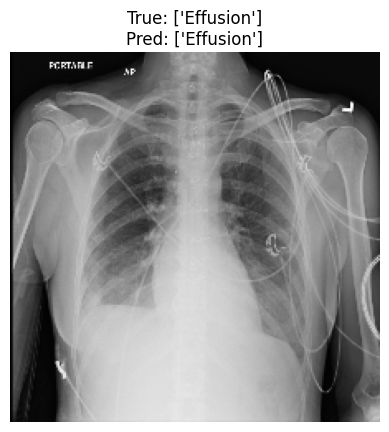

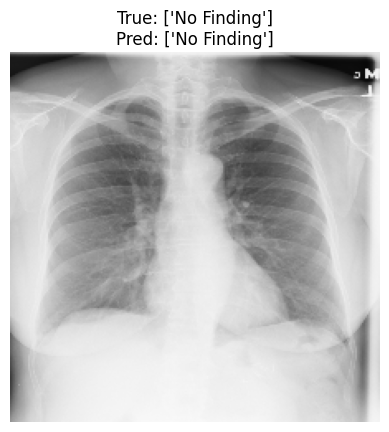

In [31]:
# --------------------------------------------
# 8. Visualize Predictions
# --------------------------------------------
def decode_label(vec):
    return [class_names[i] for i, v in enumerate(vec) if v == 1]

sample_batch = next(iter(full_ds))
images, labels = sample_batch
preds = model.predict(images)
preds = (preds > 0.5).astype(int)

for i in range(5):
    plt.imshow(images[i].numpy())
    plt.axis('off')
    plt.title(f"True: {decode_label(labels[i].numpy())}\nPred: {decode_label(preds[i])}")
    plt.show()

## Grad cam

1/1 [==============================] - 1s 647ms/step

Predicted Scores:
Atelectasis: 0.0000
Cardiomegaly: 0.9959
Consolidation: 0.0004
Edema: 0.0003
Effusion: 0.6293
Emphysema: 0.0000
Fibrosis: 0.0014
Hernia: 0.0000
Infiltration: 0.0303
Mass: 0.0000
No Finding: 0.0001
Nodule: 0.0000
Pleural_Thickening: 0.0312
Pneumonia: 0.0002
Pneumothorax: 0.0000

✅ Generating Grad-CAM for 1 high-confidence predictions:

🔍 Class: Cardiomegaly | Confidence: 0.9959


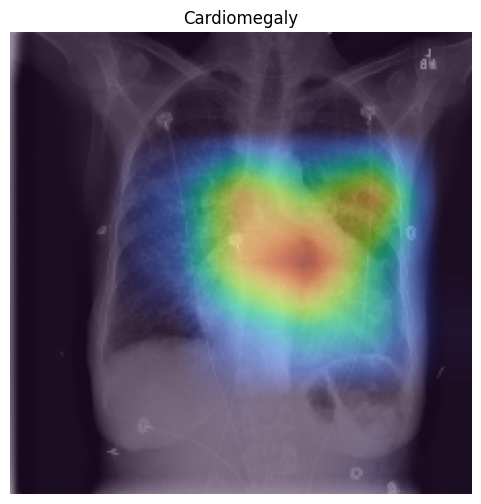

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Load your model
model = tf.keras.models.load_model(r'C:\Users\dell\Desktop\CheXzero\Tensorflow-CheX-fulldataset + GRAD\checkpoints\chest_xray_epoch_10.h5')

# Select last convolutional layer name (for ResNet50)
last_conv_layer_name = "conv5_block3_out"  # For ResNet50

# Class labels
CLASS_NAMES = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'No Finding',  # ✅ Included
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

# Preprocess a single image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return np.expand_dims(img_array, axis=0)

# Grad-CAM heatmap function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply gradients with feature maps
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on image
def display_gradcam(img_path, heatmap, title, alpha=0.5, blur=True):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # Resize and normalize the heatmap
    heatmap = cv2.resize(heatmap, (224, 224))

    # Apply optional Gaussian Blur for smoother heatmaps
    if blur:
        heatmap = cv2.GaussianBlur(heatmap, (11, 11), 0)

    # Normalize heatmap again to 0–255 range
    heatmap = np.uint8(255 * heatmap)
    
    # Use a smoother colormap like TURBO (you can try VIRIDIS or INFERNO too)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO)

    # Superimpose heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.axis('off')
    plt.imshow(superimposed_img[..., ::-1])
    plt.show()


# 🔍 Run on sample image
img_path = r"D:\CHESTXRAY\IMAGES\00004344_013.png"  # Replace as needed
img_array = preprocess_image(img_path)
preds = model.predict(img_array)[0]

# Print prediction scores
print("\nPredicted Scores:")
for i, score in enumerate(preds):
    print(f"{CLASS_NAMES[i]}: {score:.4f}")

# Automatically select classes with high confidence
threshold = 0.70
high_conf_indices = [i for i, p in enumerate(preds) if p > threshold]

if not high_conf_indices:
    print("\n❌ No class prediction above 70% confidence.")
else:
    print(f"\n✅ Generating Grad-CAM for {len(high_conf_indices)} high-confidence predictions:")
    for i in high_conf_indices:
        print(f"\n🔍 Class: {CLASS_NAMES[i]} | Confidence: {preds[i]:.4f}")
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=i)
        display_gradcam(img_path, heatmap, title=CLASS_NAMES[i])


In [38]:
# --------------------------------------------
# 7. Evaluation (F1, Precision, Recall)
# --------------------------------------------
# Collect all predictions
y_true, y_pred = [], []

for batch in full_ds:
    images, labels = batch
    preds = model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append((preds > 0.5).astype(int))

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f"🔍 F1 Score: {f1:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

1/1 [==============================] - 0s 35ms/step
🔍 F1 Score: 0.6293
✅ Precision: 0.8221
📌 Recall: 0.5409


In [24]:
print("Preds shape:", preds.shape)
print("Number of class labels:", len(CLASS_NAMES))


Preds shape: (15,)
Number of class labels: 15
